In [1]:
from pathlib import PurePath
import os
import sys
os.chdir(PurePath(os.path.abspath('')).parent)
sys.path.append(os.getcwd())

In [2]:
import numpy as np

from split_utils import read_fasta, Identity, compute_identity_stats
import matplotlib.pyplot as plt

In [3]:
MIN_SEQ_LEN = 5
MAX_SEQ_LEN = 50

# Load data

In [4]:
fasta = read_fasta("../data/build/dataset.fasta")
dataset = [int(id_) for id_, seq in fasta if MIN_SEQ_LEN <= len(seq) <= MAX_SEQ_LEN]

# Split the data into two subsets

In [5]:
indices = np.arange(len(dataset))
np.random.shuffle(indices)
test_indices = indices[:int(len(dataset) * 0.2)]
train_indices = indices[int(len(dataset) * 0.2):]
train_ids = [dataset[i] for i in train_indices]
test_ids = [dataset[i] for i in test_indices]

# Assert independence between training and test sets

In [6]:
identity_calculator = Identity()

identities, true_train_set = compute_identity_stats(train_ids, test_ids, identity_calculator=identity_calculator)
if np.isnan(identities).any():
    print("Warning: There are NaN values in the identities array. This may indicate missing data for some sequences.")

 100%|██████████████████████████████████████|  3587/3587 [08:53<00:00, 6.63it/s] 


In [7]:
test2train_id = identities.max(axis=1)

Max identity: 1.0
Mean identity: 0.8542856484865701
Median identity: 0.9166666666666666
Quantiles:
- 0.01 quantile: 0.38461538461538464
- 0.05 quantile: 0.4830923248053393
- 0.10 quantile: 0.5882352941176471
- 0.25 quantile: 0.8
- 0.50 quantile: 0.9166666666666666
- 0.75 quantile: 0.96
- 0.90 quantile: 1.0
- 0.95 quantile: 1.0
- 0.99 quantile: 1.0
Number of sequences in the training set that are not similar to any test sequence (identity > 0.5):
2054


Text(0.5, 1.0, 'Highest identity between each test sequence and all train sequences')

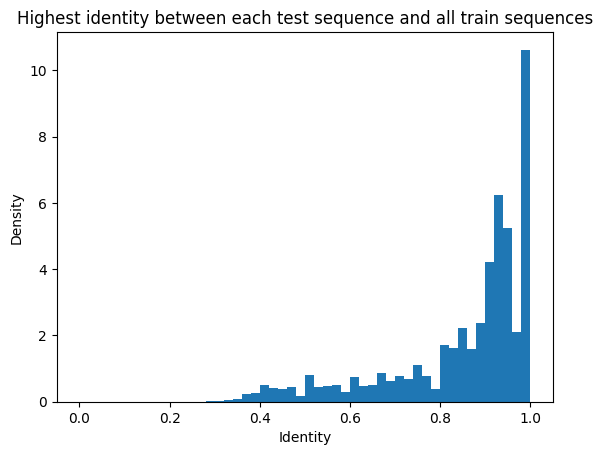

In [18]:
print(f"Max identity: {np.max(test2train_id)}")
print(f"Mean identity: {np.mean(test2train_id)}")
print(f"Median identity: {np.median(test2train_id)}")
print("Quantiles:")
for q in [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]:
    print(f"- {q:.2f} quantile: {np.quantile(test2train_id, q)}")

print("Number of sequences in the training set that are not similar to any test sequence (identity > 0.5):")
print(np.sum(true_train_set))
plt.hist(test2train_id, bins=50, range=(0, 1), density=True)
plt.xlabel("Identity")
plt.ylabel("Density")
plt.title("Highest identity between each test sequence and all train sequences")

Text(0.5, 1.0, 'Pairwise identity distribution between train and test')

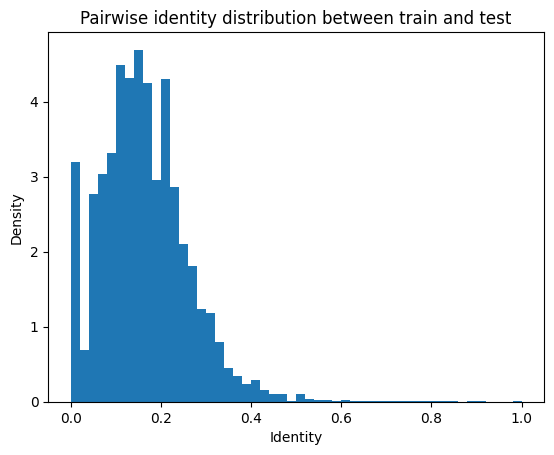

In [16]:
plt.hist(identities.reshape(-1), bins=50, range=(0, 1), density=True)
plt.xlabel("Identity")
plt.ylabel("Density")
plt.title("Pairwise identity distribution between train and test")

In [19]:
print(f"Length of train dataset: {len(train_ids)}")

Length of train dataset: 14348
